In [1]:
import pandas as pd
import os
import os.path as osp
import re
from plotnine import *

1. 读取lambda=0.1, 0.2, ... 0.9, seed=1, 2, 3时的测试结果，每个结果的csv文件中包含9个数据集的基类acc、新类acc
2. 为每个数据集计算H值
3. 将所有测试结果拼接在一起，共9(lambda=0.1,...,0.9) * 3(seed=1,2,3) * 9(9个数据集) = 243个结果

In [2]:
root = '../stats/'
filenames = os.listdir(root)

dfs = [] 
for filename in filenames:
    df = pd.read_csv(osp.join(root, filename), sep='\t', 
                     index_col=None, header=None)
    df.columns = ['dataset', 'base_acc', 'novel_acc']
    df['base_acc'] = df['base_acc'].apply(lambda x: float(x[:-1]) / 100)
    df['novel_acc'] = df['novel_acc'].apply(lambda x: float(x[:-1]) / 100)
    df['HM'] = 2 / (1 / df['base_acc'] + 1 / df['novel_acc'])

    lambda_, seed = re.findall(r'^lambda(\d\.\d)_seed(\d).csv$', filename)[0]
    df['lambda'] = lambda_
    df['seed'] = seed
    dfs.append(df)

df = pd.concat(dfs).reset_index(drop=True)
df

,dataset,base_acc,novel_acc,HM,lambda,seed
0,dtd,0.828,0.629,0.714910,0.8,2
1,caltech,0.987,0.945,0.965543,0.8,2
2,eurosat,0.899,0.697,0.785217,0.8,2
3,ucf101,0.857,0.756,0.803338,0.8,2
4,flowers,0.974,0.739,0.840381,0.8,2
...,...,...,...,...,...,...
238,flowers,0.960,0.736,0.833208,0.2,1
239,pets,0.953,0.983,0.967768,0.2,1
240,cars,0.729,0.744,0.736424,0.2,1
241,aircraft,0.366,0.373,0.369467,0.2,1


按照数据集和lambda设置分组并求均值，得到每个不同lambda设置下各个数据集的平均结果

(这里H值需要重新计算，而非所有seed的H值的均值)

In [3]:
mean_df = df.groupby(['dataset', 'lambda']).mean(['base_acc', 'novel_acc', 'HM']).reset_index()
mean_df['HM'] = 2 / (1 / mean_df['base_acc'] + 1 / mean_df['novel_acc'])
mean_df['seed'] = 'average'
df = pd.concat([df, mean_df]).reset_index(drop=True)
df

,dataset,base_acc,novel_acc,HM,lambda,seed
0,dtd,0.828000,0.629000,0.714910,0.8,2
1,caltech,0.987000,0.945000,0.965543,0.8,2
2,eurosat,0.899000,0.697000,0.785217,0.8,2
3,ucf101,0.857000,0.756000,0.803338,0.8,2
4,flowers,0.974000,0.739000,0.840381,0.8,2
...,...,...,...,...,...,...
319,ucf101,0.846333,0.779667,0.811633,0.5,average
320,ucf101,0.854667,0.770333,0.810312,0.6,average
321,ucf101,0.851000,0.782333,0.815223,0.7,average
322,ucf101,0.854333,0.773333,0.811818,0.8,average


绘制各个数据集上各个seed的H值随lambda变化的变化趋势

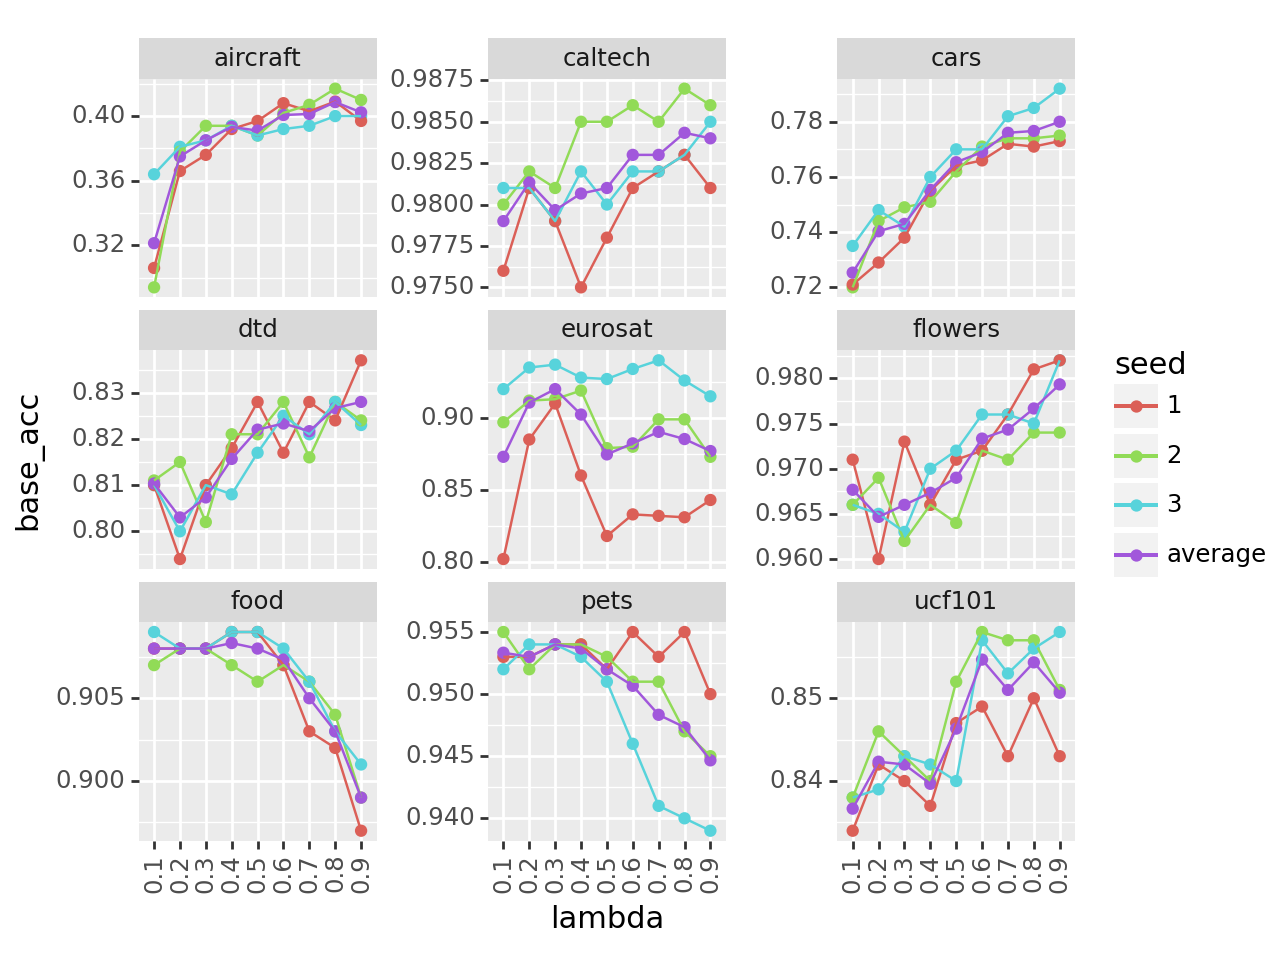

<Figure Size: (640 x 480)>

In [7]:
(
    ggplot(df, aes('lambda', 'base_acc', color='seed', group='seed'))
    + geom_point()
    + geom_line()
    + facet_wrap('dataset', scales='free_y')
    + theme(axis_text_x=element_text(rotation=90))
)

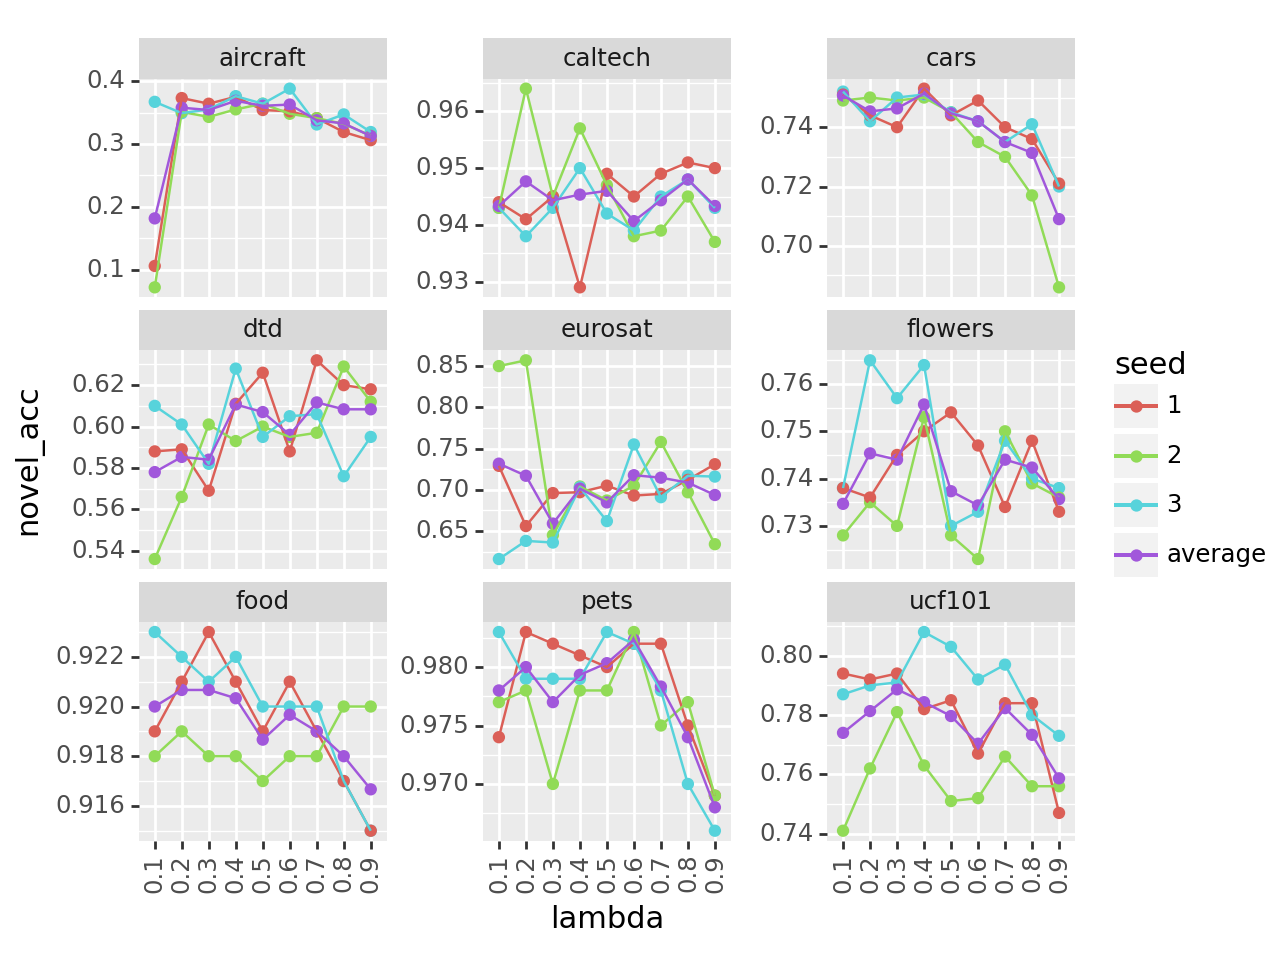

<Figure Size: (640 x 480)>

In [9]:
(
    ggplot(df, aes('lambda', 'novel_acc', color='seed', group='seed'))
    + geom_point()
    + geom_line()
    + facet_wrap('dataset', scales='free_y')
    + theme(axis_text_x=element_text(rotation=90))
)

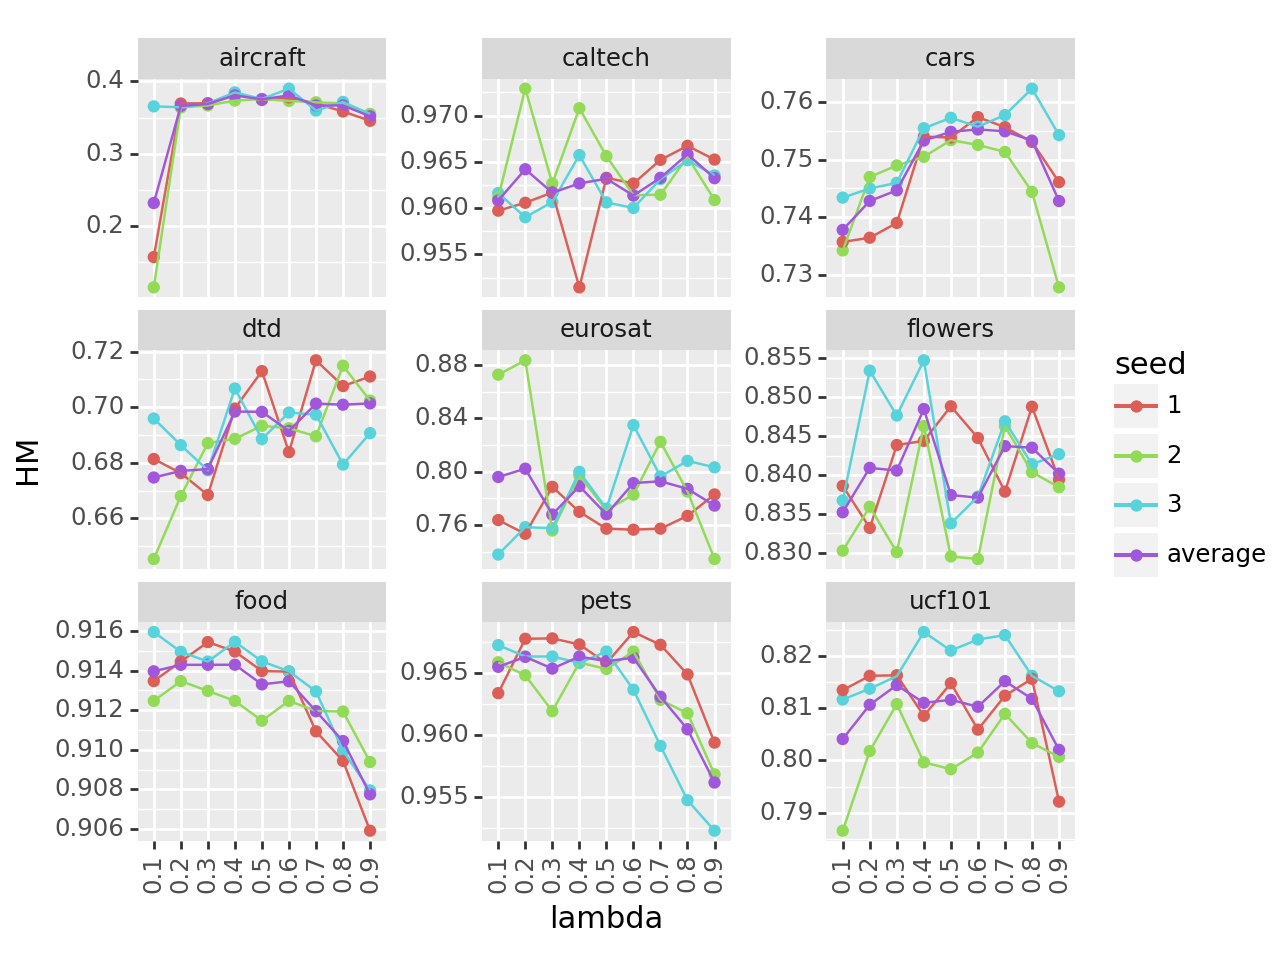

<Figure Size: (640 x 480)>

In [8]:
(
    ggplot(df, aes('lambda', 'HM', color='seed', group='seed'))
    + geom_point()
    + geom_line()
    + facet_wrap('dataset', scales='free_y')
    + theme(axis_text_x=element_text(rotation=90))
)

In [33]:
tmp_df = df[df['seed'] == 'average'].sort_values(['lambda'])

datasets = df['dataset'].drop_duplicates().tolist()

diff_dfs = []
for dataset in datasets:
    diff_df = tmp_df[tmp_df['dataset'] == dataset].drop(columns=['dataset', 'seed', 'lambda'])
    diff_df = diff_df.diff(1).dropna().mean(0).to_frame().transpose()
    diff_df['dataset'] = dataset
    diff_dfs.append(diff_df)

diff_df = pd.concat(diff_dfs).reset_index(drop=True)
diff_df

,base_acc,novel_acc,HM,dataset
0,0.002208,0.003792,0.003330,dtd
1,0.000625,0.000000,0.000300,caltech
2,0.000500,-0.004750,-0.002684,eurosat
3,0.001750,-0.001917,-0.000260,ucf101
4,0.001458,0.000125,0.000621,flowers
5,-0.001083,-0.001250,-0.001165,pets
6,0.006833,-0.005208,0.000628,cars
7,0.010125,0.016375,0.014971,aircraft
8,-0.001125,-0.000417,-0.000777,food


得到各个数据集取不同seed时的最优lambda值

In [36]:
best_lambda_df = df[df['seed'] != 'average']
best_lambda_df = best_lambda_df.groupby(['dataset', 'seed']) \
                 .apply(lambda df: df[df['HM'] == df['HM'].max()]).reset_index(drop=True)

print(best_lambda_df['lambda'].astype(float).tolist())
best_lambda_df

[0.4, 0.5, 0.6, 0.8, 0.2, 0.4, 0.6, 0.5, 0.8, 0.7, 0.8, 0.4, 0.3, 0.2, 0.6, 0.5, 0.7, 0.4, 0.3, 0.2, 0.1, 0.6, 0.6, 0.1, 0.3, 0.3, 0.4]


,dataset,base_acc,novel_acc,HM,lambda,seed
0,aircraft,0.392,0.375,0.383312,0.4,1
1,aircraft,0.388,0.364,0.375617,0.5,2
2,aircraft,0.392,0.388,0.389990,0.6,3
3,caltech,0.983,0.951,0.966735,0.8,1
4,caltech,0.982,0.964,0.972917,0.2,2
5,caltech,0.982,0.950,0.965735,0.4,3
6,cars,0.766,0.749,0.757405,0.6,1
7,cars,0.762,0.745,0.753404,0.5,2
8,cars,0.785,0.741,0.762366,0.8,3
9,dtd,0.828,0.632,0.716844,0.7,1


获取各个数据集和seed的最优lambda的loss记录文件，并计算首个epoch的l1和l2均值

In [37]:
root = '../losses_bak/'
dataset_to_alias = dict(
    StanfordCars='cars',
    OxfordFlowers='flowers',
    FGVCAircraft='aircraft',
    DescribableTextures='dtd',
    Food101='food',
    UCF101='ucf101',
    OxfordPets='pets',
    EuroSAT='eurosat',
    Caltech101='caltech')

loss_dfs = []
for filename in os.listdir(root):
    if not filename.endswith('.csv'):
        continue
    
    loss_df = pd.read_csv(osp.join(root, filename))
    num_iters = len(loss_df)
    loss_df = loss_df[loss_df['iter'] < num_iters // 5]
    loss_df = loss_df[['loss_cls', 'loss_cls_lp']].mean().to_frame().transpose()

    dataset, lambda_, seed = re.findall(r'^([0-9A-Za-z]+)_lambda(\d\.\d)_seed(\d).csv$', filename)[0]
    loss_df['dataset'] = dataset_to_alias[dataset]
    loss_df['lambda'] = lambda_
    loss_df['seed'] = seed
    
    loss_dfs.append(loss_df)

loss_df = pd.concat(loss_dfs).reset_index(drop=True)
loss_df

,loss_cls,loss_cls_lp,dataset,lambda,seed
0,1.640937,4.611428,cars,0.5,2
1,1.757306,3.974150,flowers,0.7,2
2,2.633325,3.937637,aircraft,0.4,1
3,1.824538,3.194092,dtd,0.4,3
4,0.675791,3.939520,food,0.1,3
5,1.770763,3.963523,flowers,0.5,1
6,0.599860,3.938057,caltech,0.8,1
7,1.344105,3.944882,ucf101,0.3,1
8,0.658509,3.966127,food,0.2,2
9,0.797525,2.983681,pets,0.6,1


In [56]:
indexs = ['dataset', 'lambda', 'seed']
plot_df = best_lambda_df.join(loss_df.set_index(indexs), on=indexs)
plot_df['lambda'] = plot_df['lambda'].astype(float)
plot_df

,dataset,base_acc,novel_acc,HM,lambda,seed,loss_cls,loss_cls_lp
0,aircraft,0.392,0.375,0.383312,0.4,1,2.633325,3.937637
1,aircraft,0.388,0.364,0.375617,0.5,2,2.604707,3.941328
2,aircraft,0.392,0.388,0.389990,0.6,3,2.684019,3.948105
3,caltech,0.983,0.951,0.966735,0.8,1,0.599860,3.938057
4,caltech,0.982,0.964,0.972917,0.2,2,0.609877,3.938984
5,caltech,0.982,0.950,0.965735,0.4,3,0.651058,3.932900
6,cars,0.766,0.749,0.757405,0.6,1,1.668160,4.619629
7,cars,0.762,0.745,0.753404,0.5,2,1.640937,4.611428
8,cars,0.785,0.741,0.762366,0.8,3,1.651811,4.601732
9,dtd,0.828,0.632,0.716844,0.7,1,1.604043,3.217041


最优lambda到底和什么有关：
1. 和l1有关？√成正比
2. 和l2有关？X
3. 和l1/l2的组合有关？X

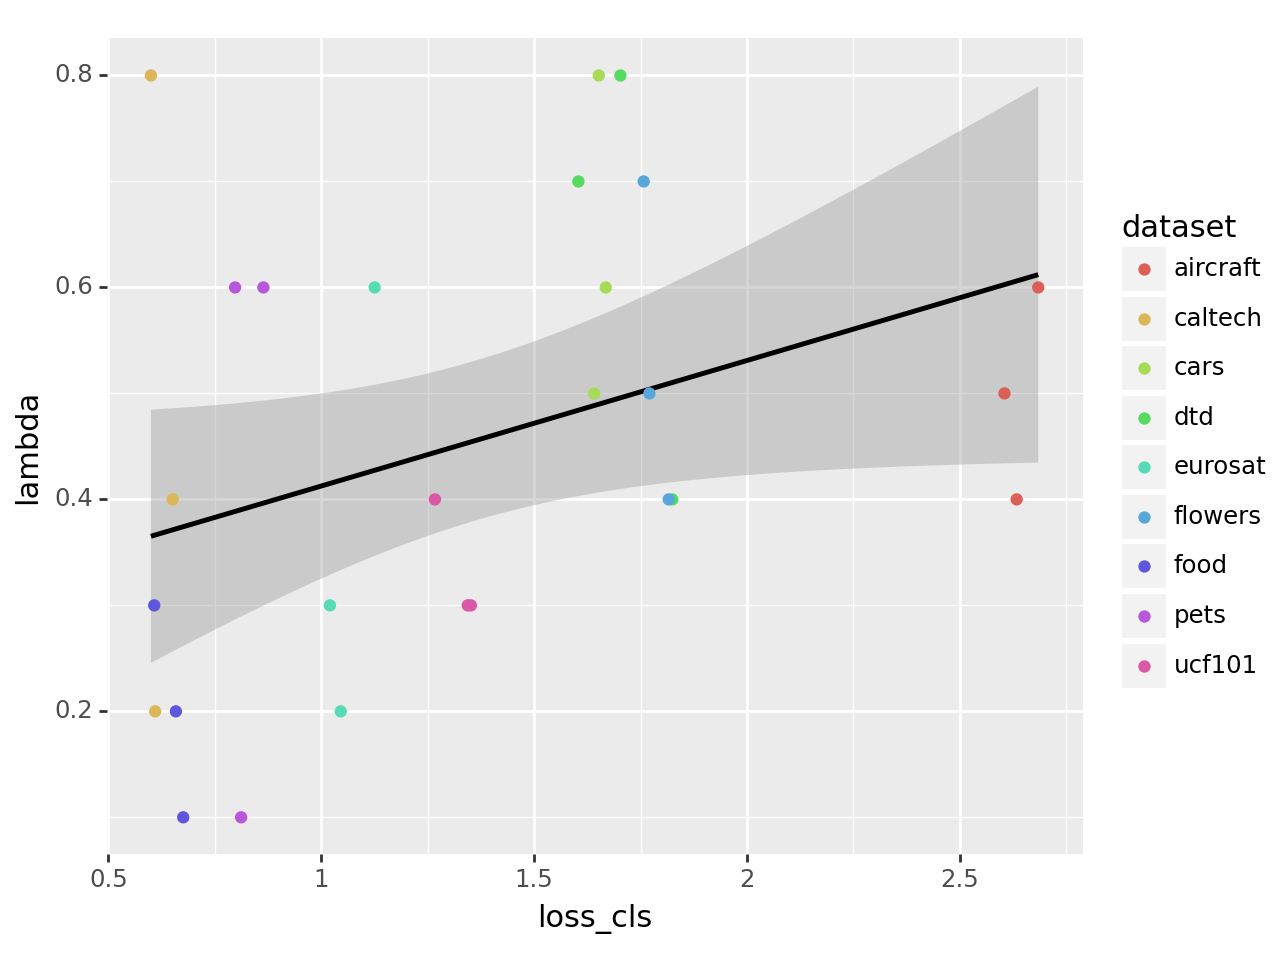

<Figure Size: (640 x 480)>

In [57]:
# plot_df = plot_df[plot_df['seed'] == '1']
(
    ggplot(plot_df, aes('loss_cls', 'lambda'))
    + geom_smooth(method='glm')
    + geom_point(aes(color='dataset'))
)

/ai/zhangji/wuhao/miniconda3/envs/maple/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 30 rows containing missing values.


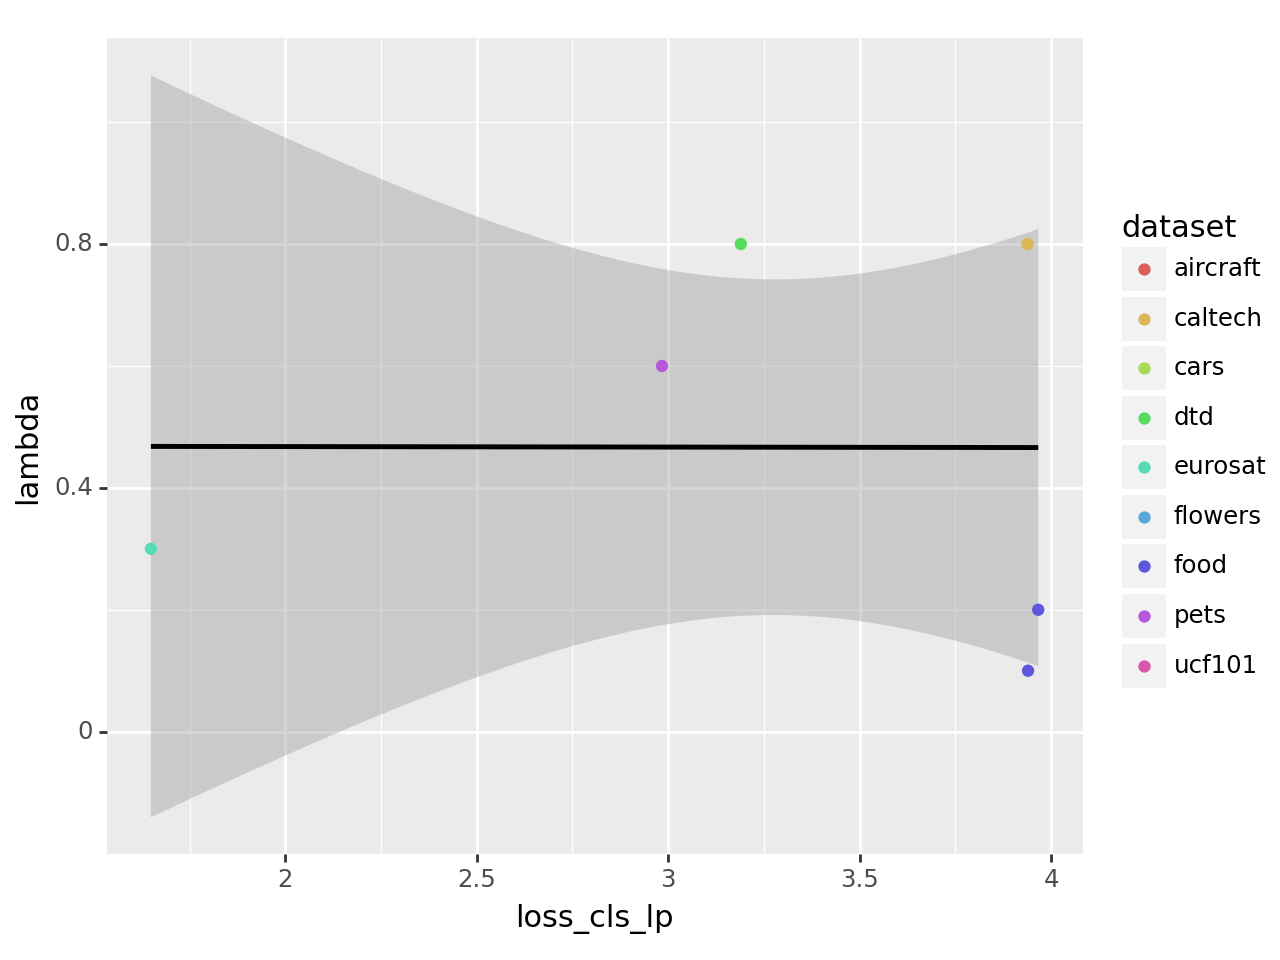

<Figure Size: (640 x 480)>

In [21]:
(
    ggplot(plot_df, aes('loss_cls_lp', 'lambda'))
    + geom_smooth(method='glm')
    + geom_point(aes(color='dataset'))
)

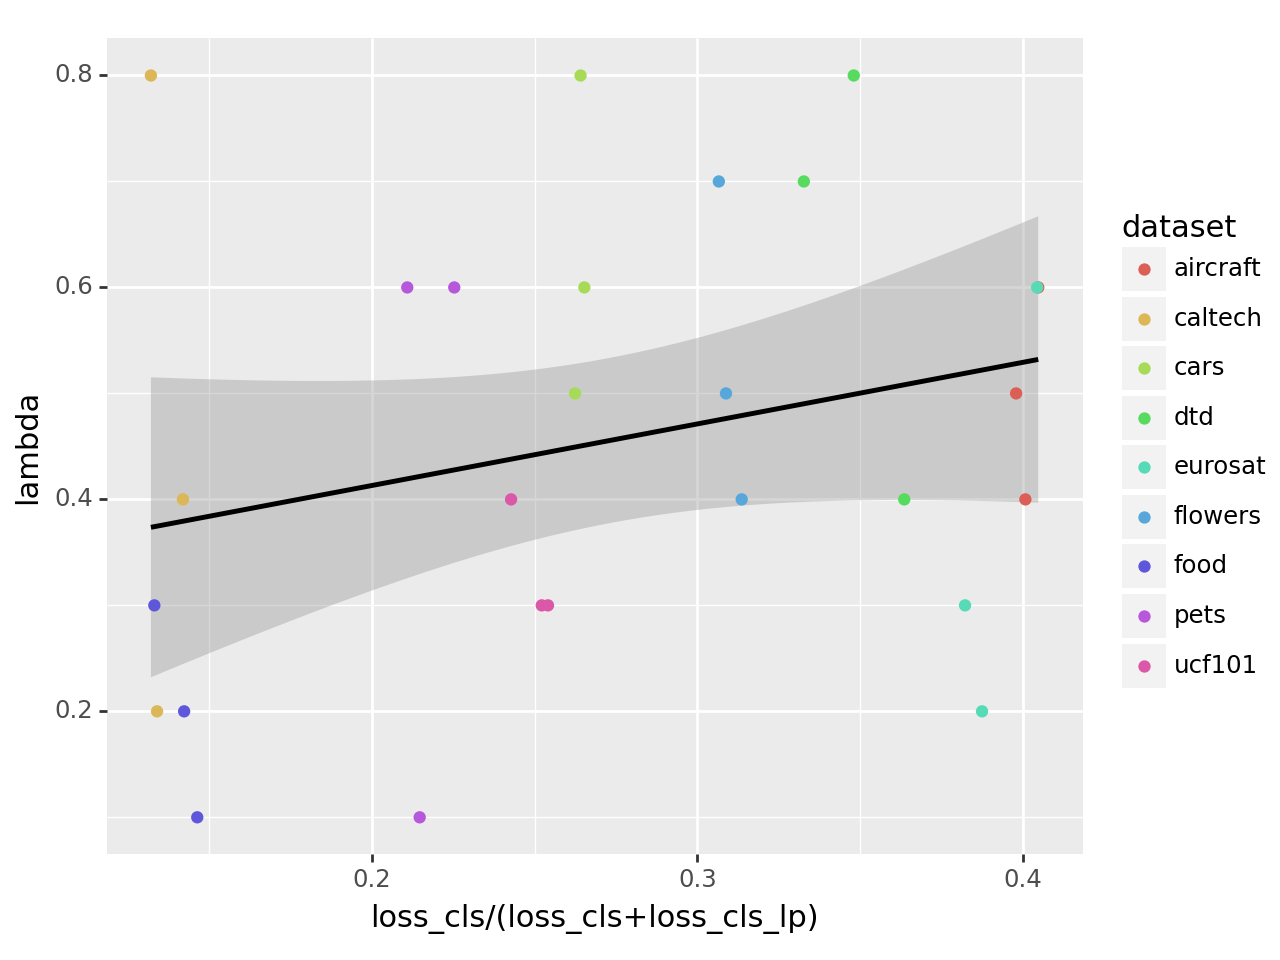

<Figure Size: (640 x 480)>

In [10]:
(
    ggplot(plot_df, aes('loss_cls/(loss_cls+loss_cls_lp)', 'lambda'))
    + geom_smooth(method='glm')
    + geom_point(aes(color='dataset'))
)

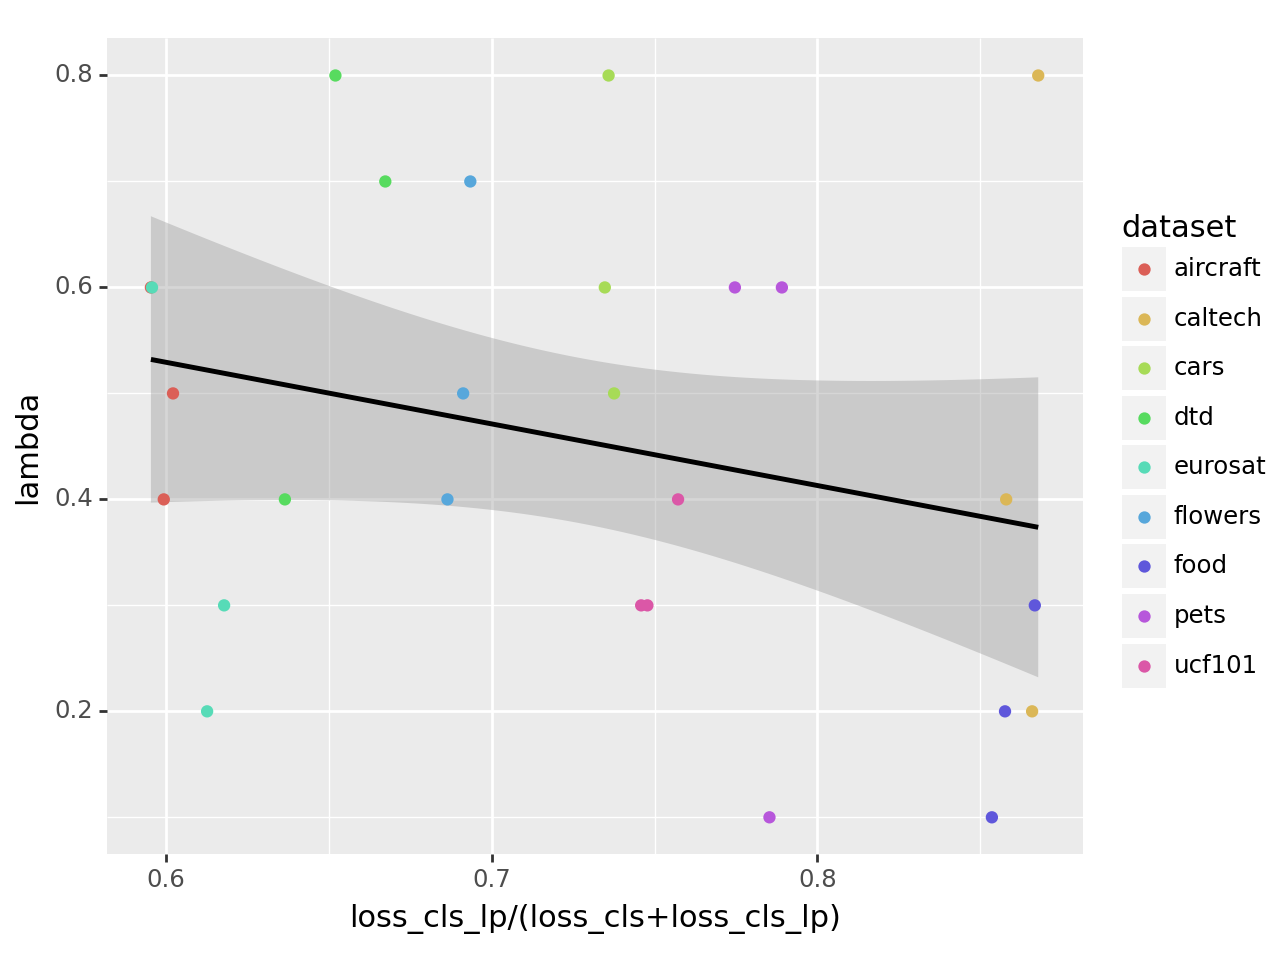

<Figure Size: (640 x 480)>

In [11]:
(
    ggplot(plot_df, aes('loss_cls_lp/(loss_cls+loss_cls_lp)', 'lambda'))
    + geom_smooth(method='glm')
    + geom_point(aes(color='dataset'))
)

l1和最优lambda的取值一致呈S形关系，采用双S曲线拟合
$$
y=\frac{1-\exp(-x/t)}{1+\exp(-x/t)}
$$
其中t是可调的温度参数，决定曲线的陡峭程度

func: (1 - exp(-x/1.20)) / (1 + exp(-x/1.20))
[0.8, 0.8, 0.81, 0.24, 0.25, 0.26, 0.6, 0.59, 0.6, 0.58, 0.61, 0.64, 0.4, 0.41, 0.44, 0.63, 0.62, 0.64, 0.25, 0.27, 0.27, 0.32, 0.35, 0.33, 0.51, 0.51, 0.48]


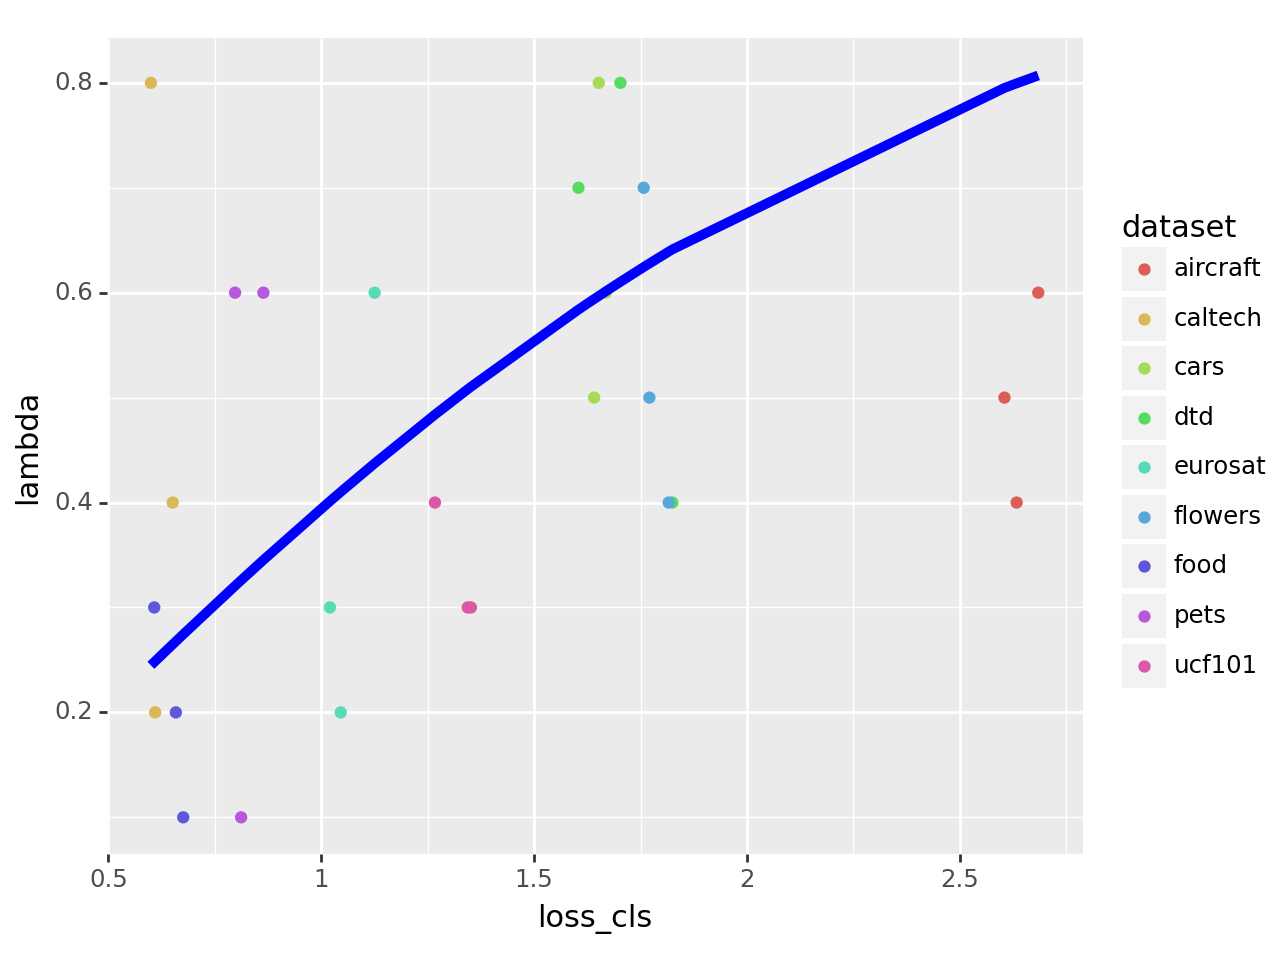

<Figure Size: (640 x 480)>

In [12]:
import numpy as np
from scipy.optimize import curve_fit

def f(x, t): 
    return (1 - np.exp(-x / t)) / (1 + np.exp(-x / t))

xs = plot_df['loss_cls'].to_numpy()
ys = plot_df['lambda'].to_numpy()
t = curve_fit(f, xs, ys)[0][0]
t = 1.2
print('func: (1 - exp(-x/{:.2f})) / (1 + exp(-x/{:.2f}))'.format(t, t))

lambdas_pred = [f(x, t) for x in xs]
print([float('{:.2f}'.format(x)) for x in lambdas_pred])
plot_df['lambda_pred'] = lambdas_pred
(
    ggplot(plot_df, aes('loss_cls', 'lambda'))
    + geom_point(aes(color='dataset'))
    + geom_line(aes(y='lambda_pred'), size=2, color='blue')
)

In [13]:
plot_df

,dataset,base_acc,novel_acc,HM,lambda,seed,loss_cls,loss_cls_lp,lambda_pred
0,aircraft,0.392,0.375,0.383312,0.4,1,2.633325,3.937637,0.799498
1,aircraft,0.388,0.364,0.375617,0.5,2,2.604707,3.941328,0.795154
2,aircraft,0.392,0.388,0.389990,0.6,3,2.684019,3.948105,0.806991
3,caltech,0.983,0.951,0.966735,0.8,1,0.599860,3.938057,0.244864
4,caltech,0.982,0.964,0.972917,0.2,2,0.609877,3.938984,0.248783
5,caltech,0.982,0.950,0.965735,0.4,3,0.651058,3.932900,0.264810
6,cars,0.766,0.749,0.757405,0.6,1,1.668160,4.619629,0.601227
7,cars,0.762,0.745,0.753404,0.5,2,1.640937,4.611428,0.593935
8,cars,0.785,0.741,0.762366,0.8,3,1.651811,4.601732,0.596860
9,dtd,0.828,0.632,0.716844,0.7,1,1.604043,3.217041,0.583894


In [44]:
diff_df = diff_df.join(loss_df.drop(columns=['lambda', 'seed']).groupby('dataset').mean(), on='dataset')
diff_df

,base_acc,novel_acc,HM,dataset,loss_cls,loss_cls_lp
0,0.002208,0.003792,0.003330,dtd,1.710420,3.200222
1,0.000625,0.000000,0.000300,caltech,0.620265,3.936647
2,0.000500,-0.004750,-0.002684,eurosat,1.063822,1.653418
3,0.001750,-0.001917,-0.000260,ucf101,1.320849,3.967585
4,0.001458,0.000125,0.000621,flowers,1.781374,3.970690
5,-0.001083,-0.001250,-0.001165,pets,0.824455,2.974181
6,0.006833,-0.005208,0.000628,cars,1.653636,4.610930
7,0.010125,0.016375,0.014971,aircraft,2.640684,3.942357
8,-0.001125,-0.000417,-0.000777,food,0.647328,3.952940


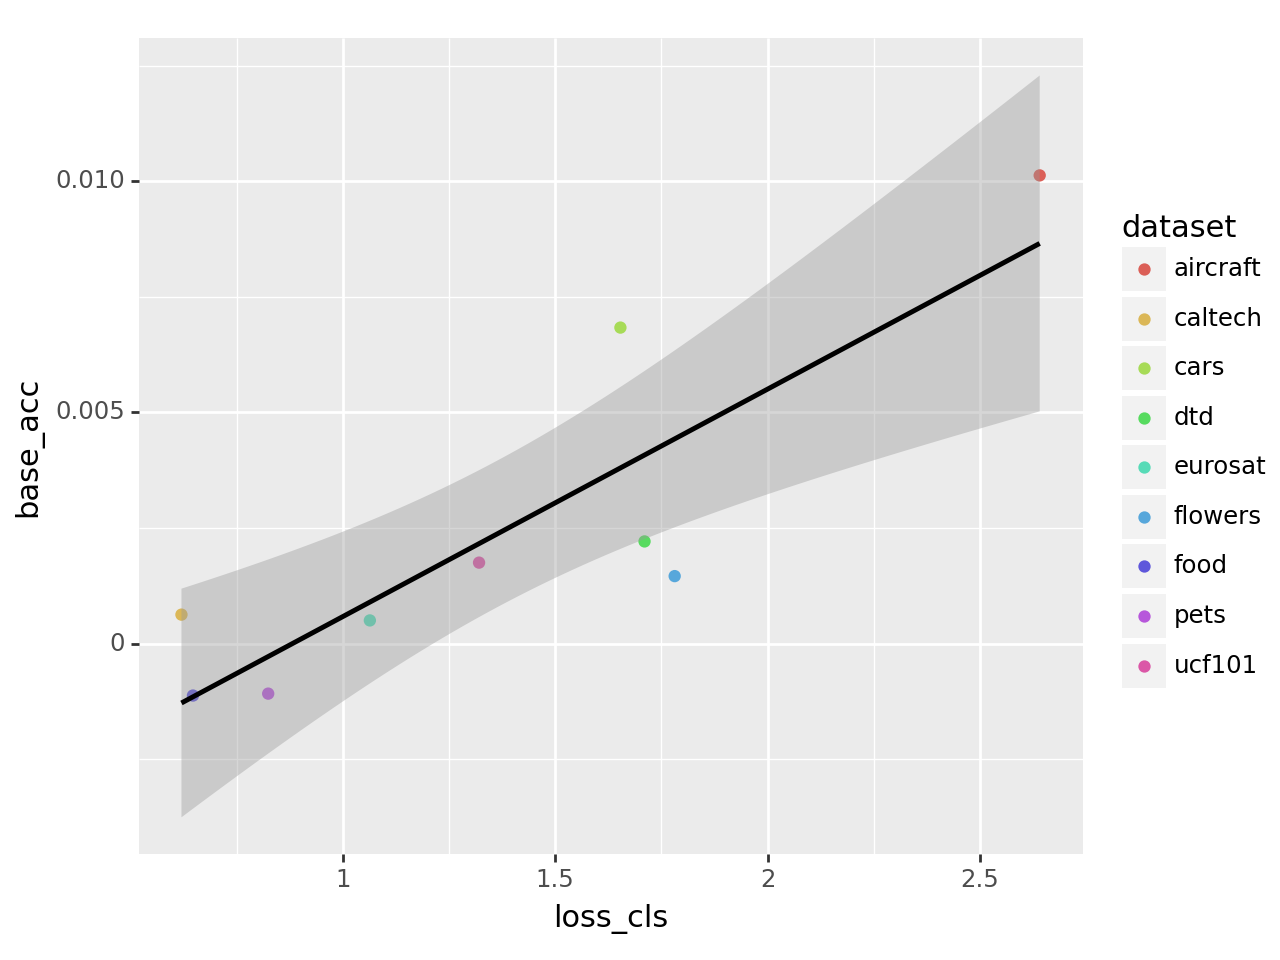

<Figure Size: (640 x 480)>

In [50]:
(
    ggplot(diff_df, aes('loss_cls', 'base_acc'))
    + geom_point(aes(color='dataset'))
    + geom_smooth(method='lm')
)

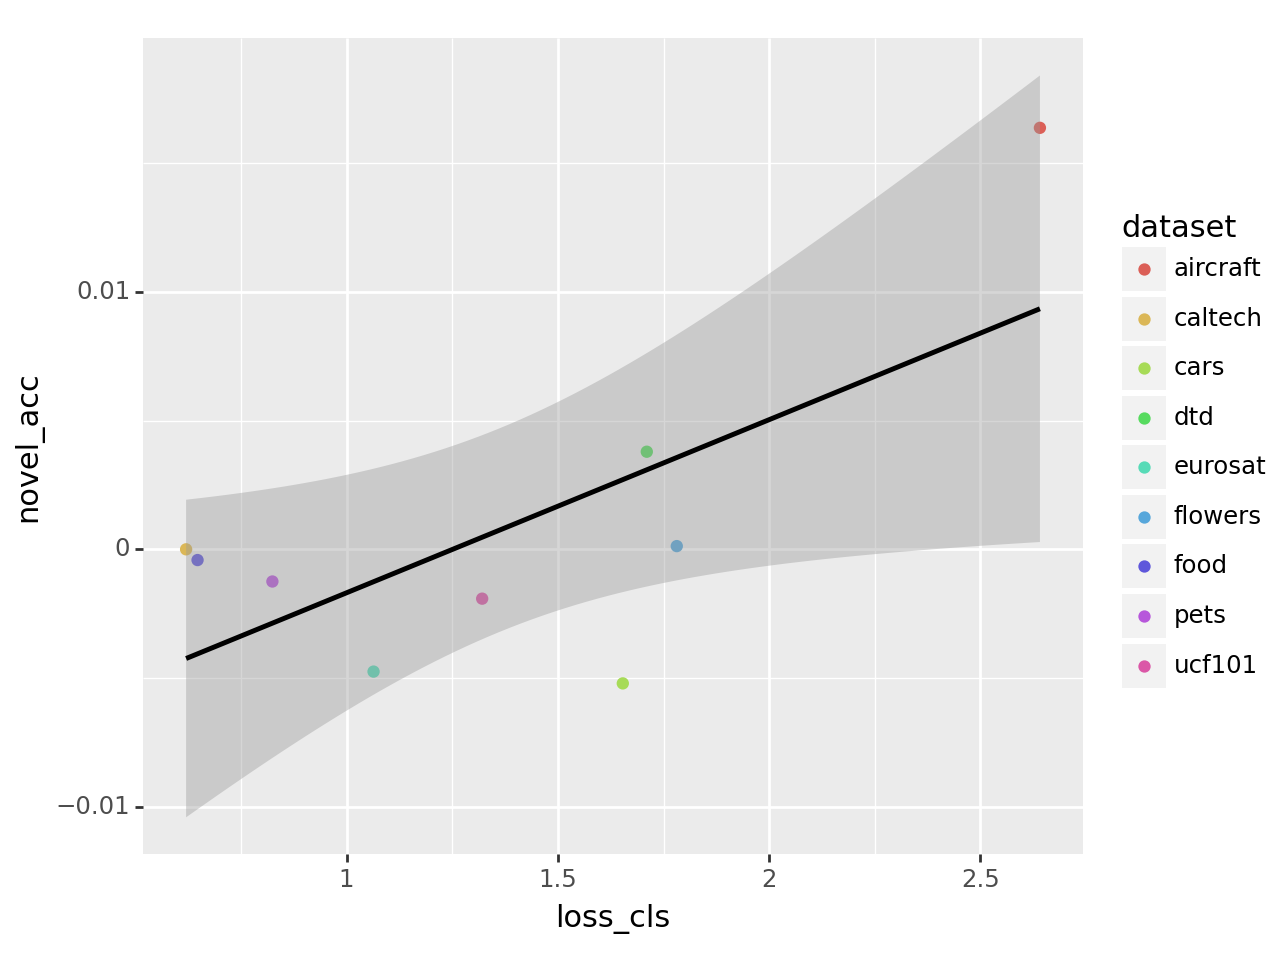

<Figure Size: (640 x 480)>

In [51]:
(
    ggplot(diff_df, aes('loss_cls', 'novel_acc'))
    + geom_point(aes(color='dataset'))
    + geom_smooth(method='lm')
)

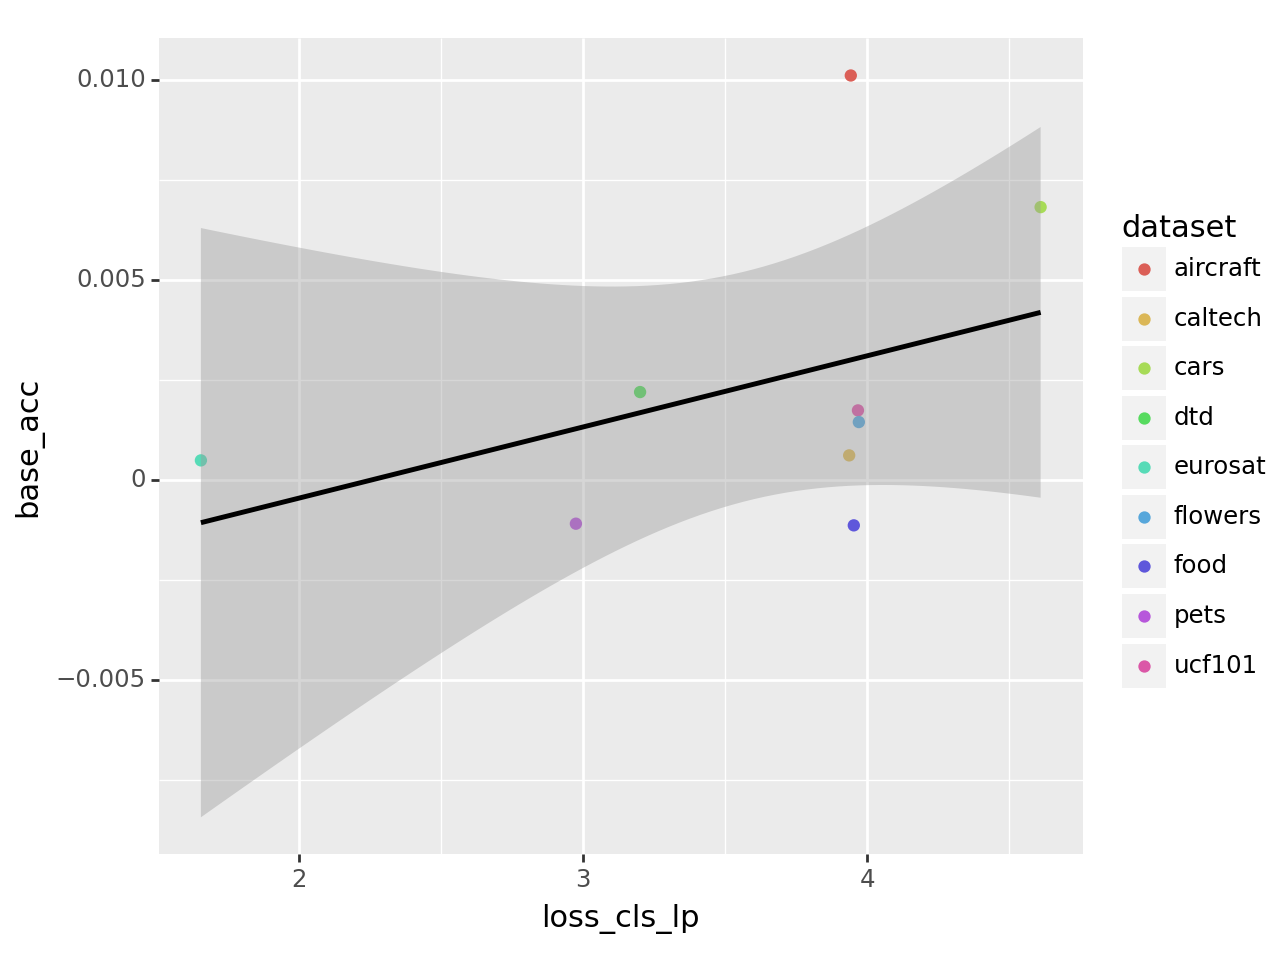

<Figure Size: (640 x 480)>

In [53]:
(
    ggplot(diff_df, aes('loss_cls_lp', 'base_acc'))
    + geom_point(aes(color='dataset'))
    + geom_smooth(method='lm')
)

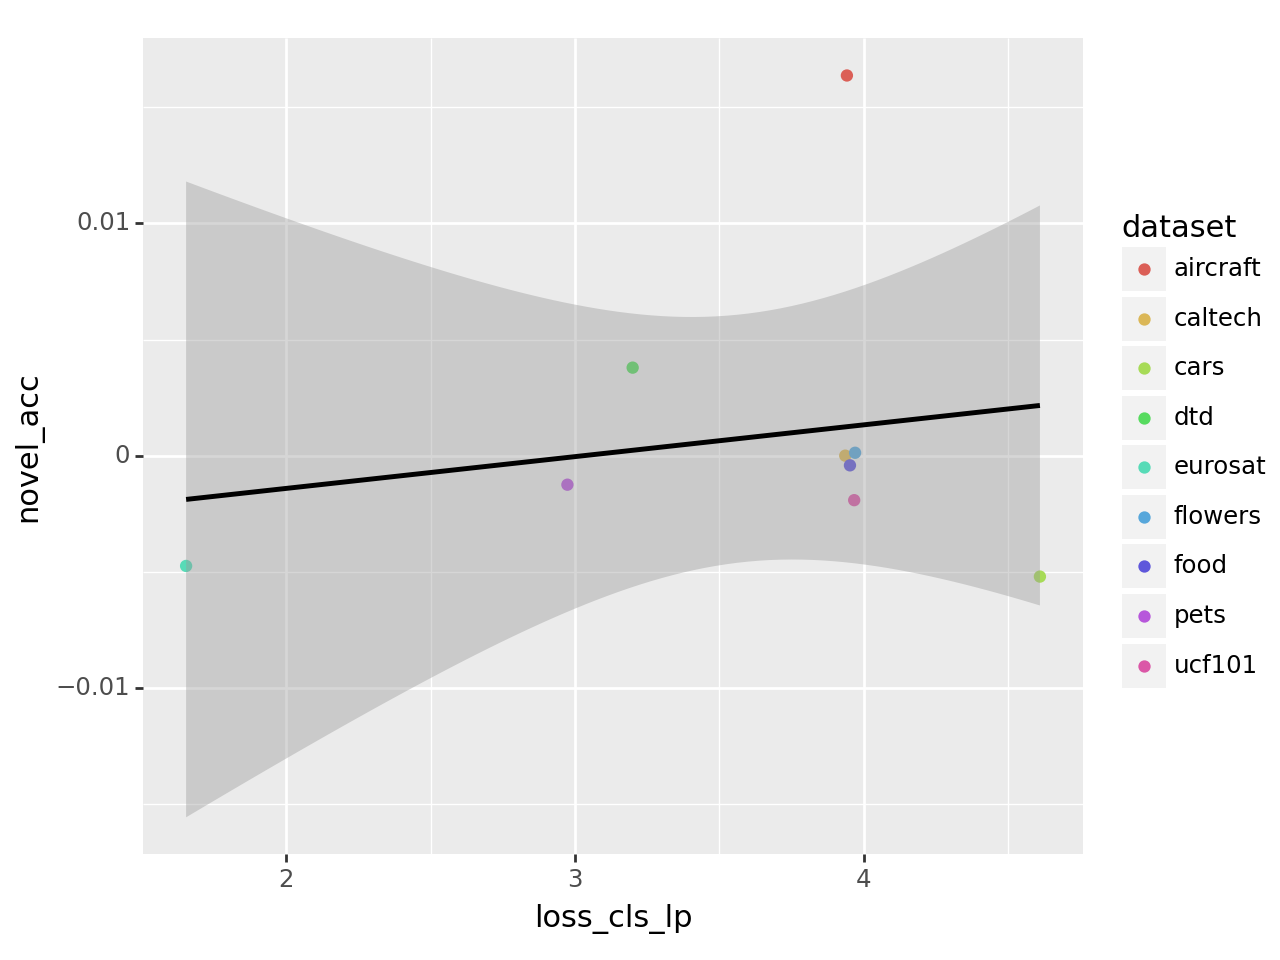

<Figure Size: (640 x 480)>

In [55]:
(
    ggplot(diff_df, aes('loss_cls_lp', 'novel_acc'))
    + geom_point(aes(color='dataset'))
    + geom_smooth(method='lm')
)